# Learnings

Based on price (density graph), we can decipher an order 
brand new > like new > lightly used > well used > heavily used
Which makes sense, as people would be willing to pay a higher price for newer items, more use => more wear and tear => less resale value

## Data Quality Checks

Look for listings with price on either extreme, bottom 1 percentile and the top 1 percentile
Weed out dummy listings, if any (manual process, time consuming, can have this as under future work)

Look for min date_sold, if very outdates can remove this row

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np

# to use with image url
from PIL import Image, ImageOps
import requests
from io import BytesIO

In [2]:
file_path = "./datasets/train.csv"
df = pd.read_csv(file_path)

In [3]:
'''
is the 'condition' column categorical?
Yes, has an order on how well the item is, but hardcoding the values is not a good idea
So we can proceed with one hot encoding for the 5conditions
'''
print(df['condition'].value_counts())
# one hot encoding the 'condition' column
df = pd.get_dummies(df, columns=['condition'], dtype=int)

condition
LIGHTLY USED    1435
LIKE NEW        1210
WELL USED        737
BRAND NEW        584
HEAVILY USED     165
Name: count, dtype: int64


In [4]:
'''
price seems to have outliers, as huge swing between 75percentile and max
'''
df.describe()

,product_id,price,condition_BRAND NEW,condition_HEAVILY USED,condition_LIGHTLY USED,condition_LIKE NEW,condition_WELL USED
count,4.131000e+03,4.131000e+03,4131.000000,4131.000000,4131.000000,4131.000000,4131.000000
mean,1.332517e+09,4.862931e+04,0.141370,0.039942,0.347374,0.292907,0.178407
std,1.878139e+07,3.111730e+06,0.348445,0.195846,0.476193,0.455151,0.382901
min,1.300941e+09,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.316619e+09,1.000000e+02,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.332120e+09,1.550000e+02,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.348307e+09,3.000000e+02,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.366533e+09,2.000000e+08,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
print("latest date for a transaction", df['date_sold'].max())
print("earliest date for a transaction", df['date_sold'].min())


latest date for a transaction 2025-07-08
earliest date for a transaction 2024-05-01


In [4]:
# Alternative to directly passing in date and month as numbers
def cyclical_encode(value, max_value):
    sin_val = round(np.sin(2 * np.pi * value / max_value), 2)
    cos_val = round(np.cos(2 * np.pi * value / max_value), 2)
    return sin_val, cos_val

# Example for day of week (0 to 6)
for day_of_week in range(7):
    sin_dow, cos_dow = cyclical_encode(day_of_week, 7)
    print(f"Day of Week {day_of_week}: sin={sin_dow}, cos={cos_dow}")


Day of Week 0: sin=0.0, cos=1.0
Day of Week 1: sin=0.78, cos=0.62
Day of Week 2: sin=0.97, cos=-0.22
Day of Week 3: sin=0.43, cos=-0.9
Day of Week 4: sin=-0.43, cos=-0.9
Day of Week 5: sin=-0.97, cos=-0.22
Day of Week 6: sin=-0.78, cos=0.62


In [5]:
df['date_sold'] = pd.to_datetime(df['date_sold'])
df['year'] = df['date_sold'].dt.year

df['month_sin'], df['month_cos'] = zip(
    *df['date_sold'].dt.month.apply(lambda x: cyclical_encode(x, 12))
    )
df['day_of_week_sin'], df['day_of_week_cos'] = zip(
    *df['date_sold'].dt.dayofweek.apply(lambda x: cyclical_encode(x, 7))
    )

df.drop('date_sold', axis=1, inplace=True)

count    4.131000e+03
mean     4.862931e+04
std      3.111730e+06
min      0.000000e+00
25%      1.000000e+02
50%      1.550000e+02
75%      3.000000e+02
max      2.000000e+08
Name: price, dtype: float64


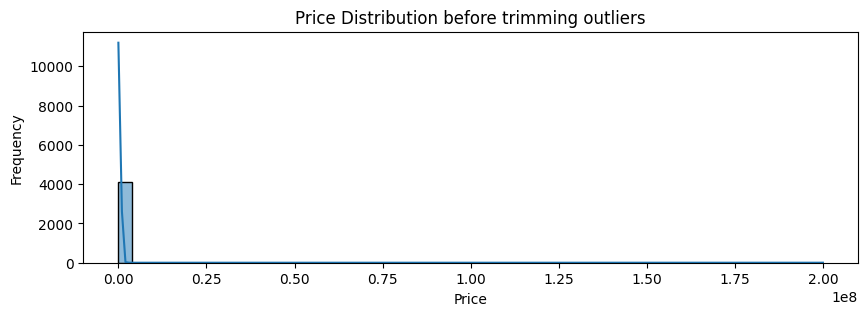

In [8]:
print(df['price'].describe())
plt.figure(figsize=(10, 3))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Price Distribution before trimming outliers')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

price outliers: 1
rows said to be outliers are [188] for which the price was [2.e+08]
count    4130.000000
mean      214.938065
std       205.821673
min         0.000000
25%       100.000000
50%       155.000000
75%       300.000000
max      5600.000000
Name: price, dtype: float64


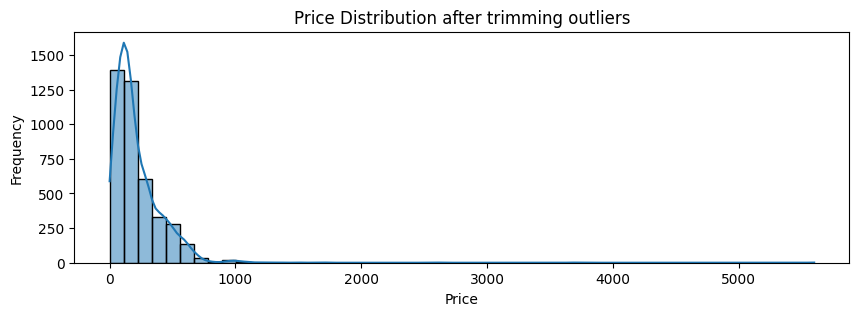

In [6]:
# flag rows with price >= mean + 3*std as outliers
outlier_price_condition = df['price'] >= df['price'].mean() + 3* df['price'].std()

print("price outliers:", df[outlier_price_condition].shape[0])
print("rows said to be outliers are", df[outlier_price_condition].index.tolist(), "for which the price was",
      df[outlier_price_condition]['price'].values)

# remove outliers
df = df[~outlier_price_condition]

print(df['price'].describe())
plt.figure(figsize=(10, 3))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Price Distribution after trimming outliers')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

Text(0.5, 1.0, 'log price')

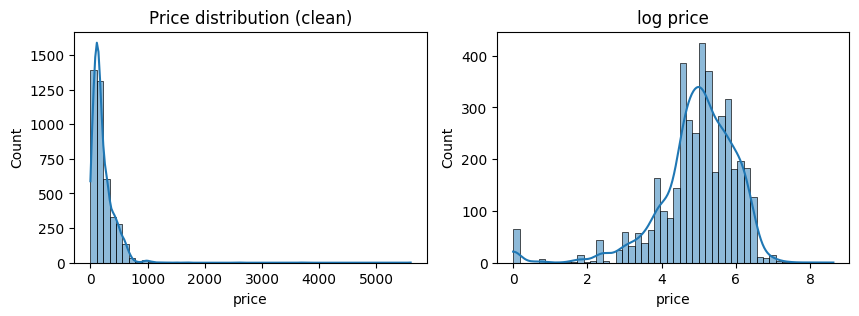

In [7]:
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Price distribution (clean)')

plt.subplot(1,2,2)
sns.histplot(np.log1p(df['price']), bins=50, kde=True)
plt.title('log price')

In [8]:
df['price_log'] = np.log1p(df['price'])
df.drop('price', axis=1, inplace=True)

df["year"] = (df["year"] - 2024)

df.to_csv('./datasets/train_cleaned.csv', index=False)

In [9]:
df.describe()

,product_id,condition_BRAND NEW,condition_HEAVILY USED,condition_LIGHTLY USED,condition_LIKE NEW,condition_WELL USED,year,month_sin,month_cos,day_of_week_sin,day_of_week_cos,price_log
count,4.130000e+03,4130.000000,4130.000000,4130.000000,4130.000000,4130.000000,4130.000000,4130.000000,4130.000000,4130.000000,4130.000000,4130.000000
mean,1.332512e+09,0.141404,0.039952,0.347215,0.292978,0.178450,0.345763,-0.017913,0.000702,-0.037223,0.020688,4.958370
std,1.878005e+07,0.348480,0.195869,0.476143,0.455184,0.382938,0.475674,0.699383,0.717818,0.712333,0.695946,1.105960
min,1.300941e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-0.970000,-0.900000,0.000000
25%,1.316613e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.870000,-0.870000,-0.780000,-0.900000,4.615121
50%,1.332118e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.220000,5.049856
75%,1.348298e+09,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.500000,0.870000,0.780000,0.620000,5.707110
max,1.366533e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.970000,1.000000,8.630700


In [194]:
df.head(2)

,product_id,title,description,image_url,condition_BRAND NEW,condition_HEAVILY USED,condition_LIGHTLY USED,condition_LIKE NEW,condition_WELL USED,year,month_sin,month_cos,day_of_week_sin,day_of_week_cos,price_log
0,1317124235,🎧Mon🎧 Modded 3DS | 2DS | XL |new |Nintendo | l...,"👍 applicable to old 2ds/3ds, new 2ds 3ds xl \...",https://media.karousell.com/media/photos/produ...,1,0,0,0,0,2024,-0.87,-0.50,0.43,-0.9,3.430756
1,1349325086,Pokemon Nintendo 2DS XL Brand new,Brand new. Box never been open before. To deal...,https://media.karousell.com/media/photos/produ...,1,0,0,0,0,2025,0.50,0.87,0.00,1.0,6.685861


         product_id        price  title_length  description_length
count  4.130000e+03  4130.000000   4130.000000         4130.000000
mean   1.332512e+09   214.938065     27.045036          178.643584
std    1.878005e+07   205.821673     20.030067          230.125032
min    1.300941e+09     0.000000      3.000000            1.000000
25%    1.316613e+09   100.000000     14.000000           62.000000
50%    1.332118e+09   155.000000     21.000000          120.000000
75%    1.348298e+09   300.000000     34.000000          217.000000
max    1.366533e+09  5600.000000    252.000000         3916.000000


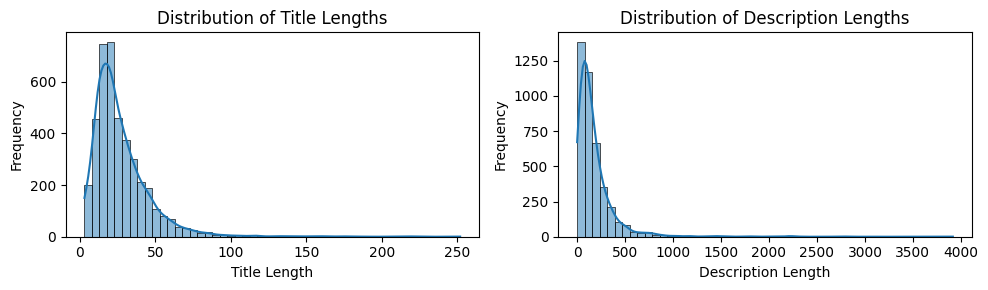

In [106]:
df['title_length'] = df['title'].apply(lambda x: len(str(x)))
df['description_length'] = df['description'].apply(lambda x: len(str(x)))

print(df.describe())

plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
sns.histplot(df['title_length'], bins=50, kde=True)
plt.title('Distribution of Title Lengths')
plt.xlabel('Title Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['description_length'], bins=50, kde=True)
plt.title('Distribution of Description Lengths')
plt.xlabel('Description Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# for rows having title length greater than 75th percentile, we can limit the title to the first N characters where N is the 75th percentile for all title lengths
title_length_75th_percentile = int(df['title_length'].quantile(0.75))
df['title'] = df['title'].apply(lambda x: str(x)[:title_length_75th_percentile] if len(str(x)) > title_length_75th_percentile else x)
# for rows having description length greater than 75th percentile, we can limit the description to the first N characters where N is the 75th percentile for all description lengths
description_length_75th_percentile = int(df['description_length'].quantile(0.75))
df['description'] = df['description'].apply(lambda x: str(x)[:description_length_75th_percentile] if len(str(x)) > description_length_75th_percentile else x)
print("After trimming title and description lengths:")

print("Title Length 75th Percentile:", title_length_75th_percentile)
print("Description Length 75th Percentile:", description_length_75th_percentile)
print("Number of unique titles:", df['title'].nunique())
print("Number of unique descriptions:", df['description'].nunique())

After trimming title and description lengths:
Title Length 75th Percentile: 34
Description Length 75th Percentile: 217
Number of unique titles: 2631
Number of unique descriptions: 3886
         product_id        price  title_length  description_length
count  4.130000e+03  4130.000000   4130.000000         4130.000000
mean   1.332512e+09   214.938065     27.045036          178.643584
std    1.878005e+07   205.821673     20.030067          230.125032
min    1.300941e+09     0.000000      3.000000            1.000000
25%    1.316613e+09   100.000000     14.000000           62.000000
50%    1.332118e+09   155.000000     21.000000          120.000000
75%    1.348298e+09   300.000000     34.000000          217.000000
max    1.366533e+09  5600.000000    252.000000         3916.000000


         product_id        price  title_length  description_length
count  4.130000e+03  4130.000000   4130.000000         4130.000000
mean   1.332512e+09   214.938065     22.447700          125.058354
std    1.878005e+07   205.821673      9.465456           73.408495
min    1.300941e+09     0.000000      3.000000            1.000000
25%    1.316613e+09   100.000000     14.000000           62.000000
50%    1.332118e+09   155.000000     21.000000          120.000000
75%    1.348298e+09   300.000000     34.000000          217.000000
max    1.366533e+09  5600.000000     34.000000          217.000000


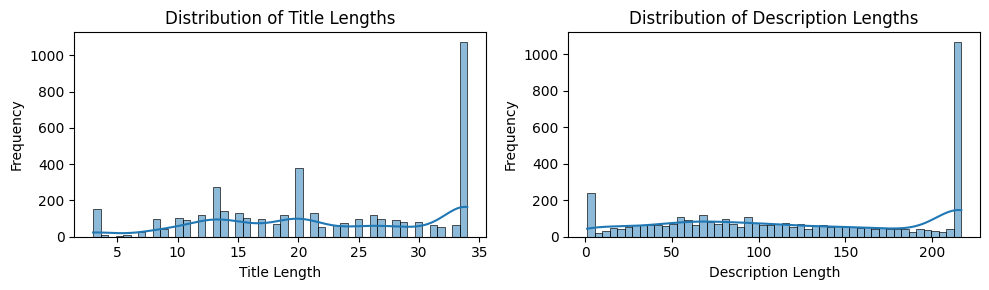

In [111]:
df['title_length'] = df['title'].apply(lambda x: len(str(x)))
df['description_length'] = df['description'].apply(lambda x: len(str(x)))

print(df.describe())

plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
sns.histplot(df['title_length'], bins=50, kde=True)
plt.title('Distribution of Title Lengths')
plt.xlabel('Title Length')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['description_length'], bins=50, kde=True)
plt.title('Distribution of Description Lengths')
plt.xlabel('Description Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Number of broken image URLs: 0


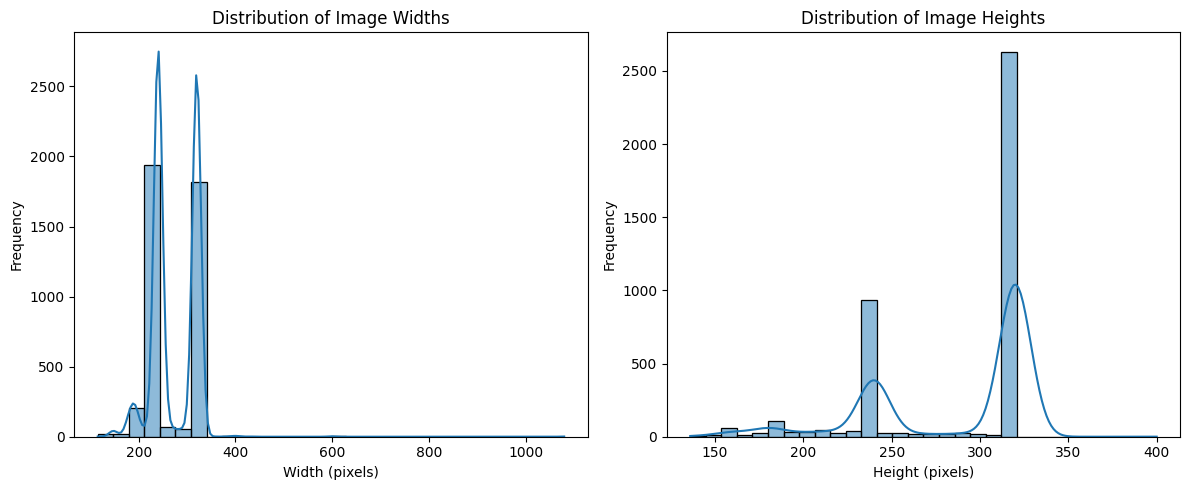

In [112]:
## 20mins to run, access 4000 images

image_widths = []
image_heights = []
broken_urls = []

for index, row in df.iterrows():
    img_url = row['image_url']
    try:
        response = requests.get(img_url, timeout=5)
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
        img = Image.open(BytesIO(response.content))
        image_widths.append(img.width)
        image_heights.append(img.height)
    except requests.exceptions.RequestException as e:
        broken_urls.append((img_url, str(e)))
    except Exception as e:
        broken_urls.append((img_url, f"Other error: {e}"))

print(f"Number of broken image URLs: {len(broken_urls)}")
if broken_urls:
    print("First 5 broken URLs:", broken_urls[:5])


In [ ]:
if image_widths and image_heights:
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 2, 1)
    sns.histplot(image_widths, bins=30, kde=True)
    plt.title('Distribution of Image Widths')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(image_heights, bins=30, kde=True)
    plt.title('Distribution of Image Heights')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()
else:
    print("No valid image dimensions to plot.")

In [158]:
# get the min, max, 50th percentile, 75th percentile for image heights and widht
print("Image Widths - Min:", np.min(image_widths), 
      ", Max:", np.max(image_widths), 
      ", 50th Percentile:", np.percentile(image_widths, 50), 
      ", 75th Percentile:", np.percentile(image_widths, 75))
print("Image Heights - Min:", np.min(image_heights),
      ", Max:", np.max(image_heights), 
      ", 50th Percentile:", np.percentile(image_heights, 50), 
      ", 75th Percentile:", np.percentile(image_heights, 75))

Image Widths - Min: 115 , Max: 1080 , 50th Percentile: 240.0 , 75th Percentile: 320.0
Image Heights - Min: 136 , Max: 400 , 50th Percentile: 320.0 , 75th Percentile: 320.0


/var/folders/1v/c5zndyld3tb4l5g9x45prpbr0000gp/T/ipykernel_52886/3392709789.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y='price', data=df, palette='viridis')


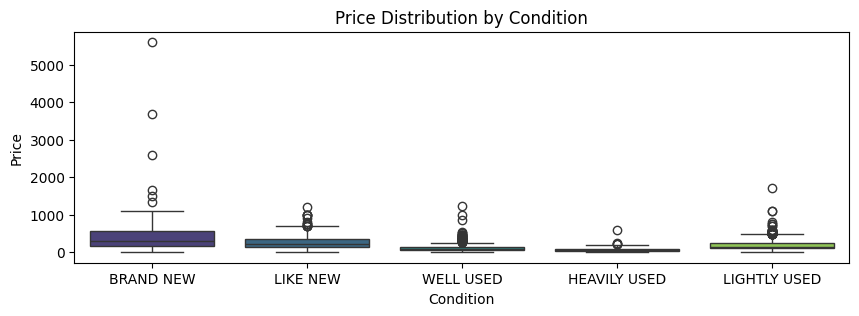

In [120]:
plt.figure(figsize=(10, 3))
sns.boxplot(x='condition', y='price', data=df, palette='viridis')
plt.title(f'Price Distribution by Condition')
plt.xlabel('Condition')
plt.ylabel('Price')
plt.show()

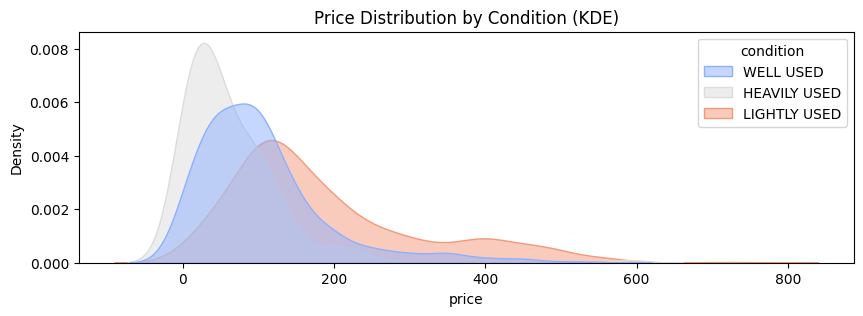

In [157]:
plt.figure(figsize=(10, 3))
sns.kdeplot(data=
            df[
                (df["price"] < 800) 
                & df['condition'].isin(["WELL USED", "LIGHTLY USED", "HEAVILY USED"]) # to focus on three condition types
            ]
            , x='price', hue='condition', fill=True, common_norm=False, palette='coolwarm', alpha=0.5)

plt.title(f'Price Distribution by Condition (KDE)')
plt.xlabel("price")
plt.ylabel('Density')
plt.show()


# Analysis that did not return much information, but still useful for overall trend analysis

- Average transaction value remains more or less constant with time, this could be a property of the category we've selected (Gaming Consoles)
- Number of transactions high towards the end of year (december)

/var/folders/1v/c5zndyld3tb4l5g9x45prpbr0000gp/T/ipykernel_52886/2773492330.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=daily_transactions.index, y=daily_transactions.values, palette='coolwarm')


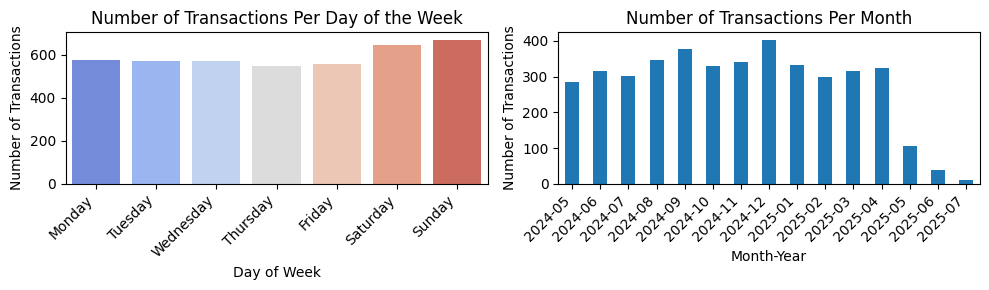

In [153]:
## Number of transactions per day of week

df['day_of_week'] = df['date_sold'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)

daily_transactions = df['day_of_week'].value_counts().sort_index()

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
sns.barplot(x=daily_transactions.index, y=daily_transactions.values, palette='coolwarm')
plt.title('Number of Transactions Per Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')

# number of transactions per month
df['date_sold'] = pd.to_datetime(df['date_sold'])
df['month_year'] = df['date_sold'].dt.to_period('M').astype(str)

monthly_transactions = df['month_year'].value_counts().sort_index()

plt.subplot(1, 2, 2)
monthly_transactions.plot(kind='bar')
plt.title('Number of Transactions Per Month')
plt.xlabel('Month-Year')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


/var/folders/1v/c5zndyld3tb4l5g9x45prpbr0000gp/T/ipykernel_52886/3997819875.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_per_day.index, y=avg_price_per_day.values, palette='viridis')


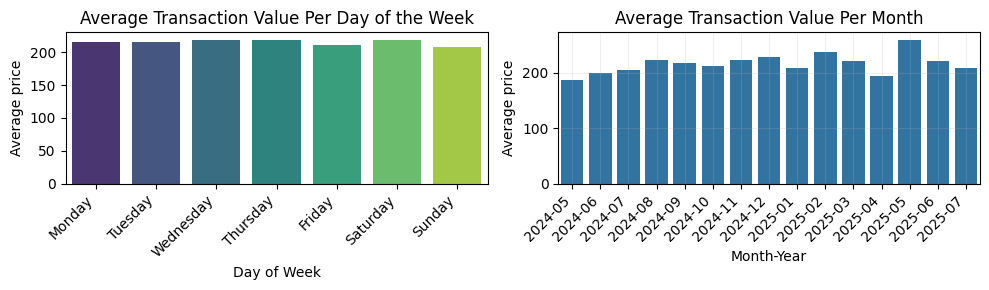

In [149]:
# transaction value per day of week, and per month

df['day_of_week'] = df['date_sold'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)
avg_price_per_day = df.groupby('day_of_week')["price"].mean().reindex(day_order)


df['month_year'] = df['date_sold'].dt.to_period('M').astype(str)
avg_price_per_month = df.groupby('month_year')["price"].mean().sort_index()

plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
sns.barplot(x=avg_price_per_day.index, y=avg_price_per_day.values, palette='viridis')
plt.title(f'Average Transaction Value Per Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel(f'Average {"price"}')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
sns.barplot(x=avg_price_per_month.index, y=avg_price_per_month.values)
plt.title(f'Average Transaction Value Per Month')
plt.xlabel('Month-Year')
plt.ylabel(f'Average {"price"}')
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()
